# Meine vierte Projekt - Waze 

### Überblick über das Geschäftsszenario

Waze ist eine Navigations-App, die ihren Nutzern Echtzeitinformationen zu Verkehr, Unfällen und Routenalternativen bietet. Die Plattform lebt von einer aktiven Community, die kontinuierlich Daten zu Verkehrsbedingungen beiträgt. Für das Unternehmen ist es entscheidend, die Nutzerbindung zu verstehen, da regelmäßige Nutzung direkt mit der Genauigkeit der Verkehrsdaten und damit mit dem Mehrwert für alle Nutzer zusammenhängt.

In diesem Szenario wird ein Datensatz betrachtet, der Informationen zu monatlicher Aktivität (z. B. Anzahl der Fahrten oder gefahrene Kilometer) sowie kumulativen Kennzahlen seit der Registrierung enthält. Ziel ist es, Muster zu identifizieren, die auf eine Abwanderung (Churn) oder fortgesetzte Nutzung hinweisen, um gezielte Maßnahmen für Nutzerbindung und Marketing entwickeln zu können.

### Arbeitsplan

1. Planung
- Identifizieren von Variablen
- Importieren der erforderlichen Pakete und Module
- Untersuchen der Daten

2. Analyse
- Datenbereinigung
- Durchführen von EDA
    - Grafiken und Figuren erstellen
    - Erste Einblicke gewinnen
- Hypothesentests durchführen

3. Konstruktion
- Feature-Engineering
- Logistische Regressionen-Modelle
- Random-Forest-Modelle
- XGBoost-Modelle
- Refactoring und Eliminierung von Faktoren
- Hyperparameter-Tuning

4. Abschluss

## 1. Planung

### Variablen definieren / Datenwörterbuch

| Variable                   | Beschreibung                                                                                               |
| -------------------------- | ---------------------------------------------------------------------------------------------------------- |
| ID                         | Eindeutige ID für jeden Nutzer im Datensatz                                                                |
| label                      | Zielvariable: Gibt an, ob der Nutzer im Beobachtungsmonat aktiv geblieben ist oder abgewandert ist (Churn) |
| sessions                   | Anzahl der App-Sitzungen des Nutzers während des Beobachtungsmonats                                        |
| drives                     | Anzahl der Fahrten (≥ 1 km) während des Beobachtungsmonats                                                 |
| total_sessions             | Gesamte Anzahl aller App-Sitzungen seit der Registrierung bis zum Ende des Beobachtungsmonats              |
| n_days_after_onboarding    | Anzahl der Tage seit der Registrierung (Onboarding) des Nutzers bis zum Ende des Beobachtungsmonats        |
| total_navigations_fav1     | Gesamte Anzahl der Navigationsvorgänge zu Favorit 1 seit der Registrierung                                 |
| total_navigations_fav2     | Gesamte Anzahl der Navigationsvorgänge zu Favorit 2 seit der Registrierung                                 |
| driven_km_drives           | Insgesamt gefahrene Kilometer während des Beobachtungsmonats                                               |
| duration_minutes_drives    | Gesamtdauer der Fahrten in Minuten während des Beobachtungsmonats                                          |
| activity_days              | Anzahl der Tage, an denen der Nutzer die App im Beobachtungsmonat genutzt hat                              |
| driving_days               | Anzahl der Tage, an denen der Nutzer im Beobachtungsmonat Fahrten durchgeführt hat                         |
| device                     | Gerätetyp, auf dem die App genutzt wird (z. B. Android oder iOS)                                           |


### Installieren und Importieren der erforderlichen Pakete und Module

1. Erstellen Sie eine virtuelle Umgebung (.venv)
2. Installieren Sie die dependencies aus der `requirements.txt`

In [543]:
# !pip install -r requirements.txt

### Erforderliche Importe

In [544]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Graphing and Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis Testing
from scipy.stats import mannwhitneyu


# Train Test Split
from sklearn.model_selection import train_test_split, GridSearchCV

# Logistic Regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Machine learning models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from xgboost import plot_importance

import pickle

# Results and Evaluation
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

### Untersuchen der Daten

#### Importieren der Daten

In [545]:
df = pd.read_csv("data/waze_dataset.csv")

#### Zusammenfassung der Daten

In [546]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


In [547]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Anmerkungen: 
- Es gibt fehlende Daten.
- Es gibt Daten, die nur den letzten Monat repräsentieren. Es ist jedoch unklar, welcher Monat gemeint ist.
- Es gibt Daten, die seit dem Beitritt des Fahrers zu Waze kumulativ sind.

## 2. Analyse

### Datenbereinigung und Durchführen von EDA

#### Fehlende Daten

Es gibt 700 Zeilen mit fehlenden Daten. Gibt es einen Grund dafür, dass die Daten fehlen?

Lassen Sie uns das untersuchen.

In [548]:
# Rows with null values
null_df = df[df['label'].isnull()]
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [549]:
# Rows without null values
not_null_df = df[~df['label'].isnull()]
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Die zusammenfassenden Statistiken sind zwischen den fehlenden und den nicht fehlenden Datensätzen ähnlich.

Möglicherweise ist das verwendete Gerät ein logischer Grund für die fehlenden Daten.

Apple oder Android in den Variable `device`

In [550]:
df['device'].value_counts(normalize=True)

device
iPhone     0.644843
Android    0.355157
Name: proportion, dtype: float64

In [551]:
null_df['device'].value_counts(normalize=True)

device
iPhone     0.638571
Android    0.361429
Name: proportion, dtype: float64

#### Zusammenfassende Statistik, gruppiert nach `label`

In [552]:
df.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


Wir verwenden den Median anstelle des Mean, da die Daten eine hohe Anzahl von Ausreißern enthält.

Die `churned` Personen haben im letzten Monat mehr gearbeitet, jedoch weniger häufig.

Berechnung der vom Benutzer pro Tag zurückgelegten Distanz.

In [553]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

In [554]:
median_km_per_driving_day = df.groupby('label').median(numeric_only=True)[['km_per_driving_day']]
median_km_per_driving_day

,km_per_driving_day
label,
churned,697.541999
retained,289.549333


Berechnung der Anzahl der Fahrten, die der Benutzer pro Tag gefahren ist.

In [555]:
df['drives_per_driving_day'] = df['drives'] / df['driving_days']
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0

In [556]:
median_drives_per_driving_day = df.groupby('label').median(numeric_only=True)[['drives_per_driving_day']]
median_drives_per_driving_day

,drives_per_driving_day
label,
churned,5.500000
retained,3.470588


Man kann wohl davon annehmen, dass diese Daten nicht repräsentativ für die meisten Fahrer sind. Vielleicht gibt es in den Daten, vor allem bei den abgewanderten Nutzern, einen hohen Anteil an Fernfahrern.

Angesichts der Tatsache, wie viel diese Nutzer fahren, wäre es sinnvoll, Waze zu empfehlen, mehr Daten über diese Vielfahrer zu sammeln. 

Untersuchen, ob es ein Ungleichgewicht bei der Anzahl der Abwanderungen nach Gerätetyp gibt.

In [557]:
df.groupby('label')['device'].value_counts(normalize=True)

label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: proportion, dtype: float64

Das Verhältnis zwischen iPhone-Nutzern und Android-Nutzern ist in der Gruppe der Abwanderer und der Gruppe der Verbleiber konsistent, und diese Verhältnisse stimmen beide mit dem Verhältnis im Gesamtdatensatz überein.

#### Grafiken und Figuren

##### `sessions`

Die Anzahl der Fälle, in denen ein Benutzer die App im Laufe des Monats geöffnet hat.

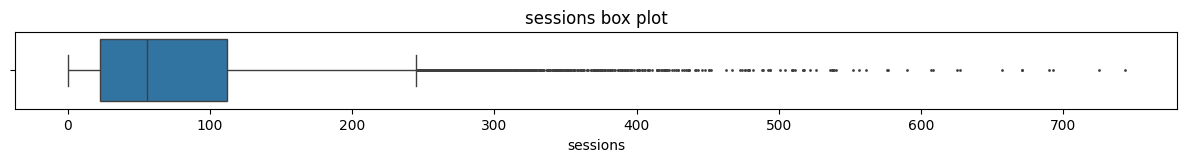

In [558]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('sessions box plot');

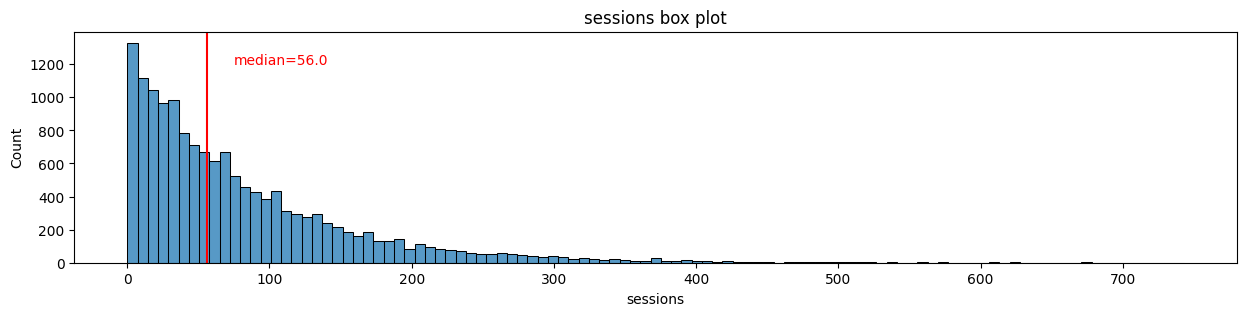

In [559]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions box plot');

Die Variable `sessions` hat eine rechtsschiefe Verteilung.

##### `drives`

Eine Fahrt von mindestens 1 km im Monatsverlauf

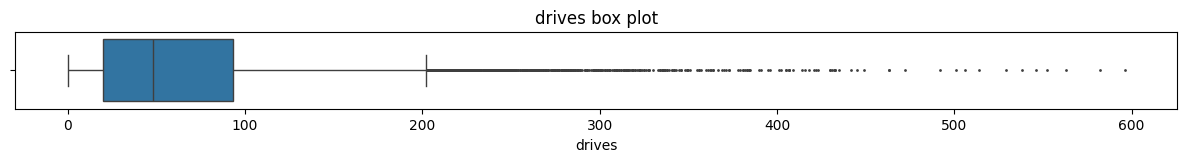

In [560]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('drives box plot');

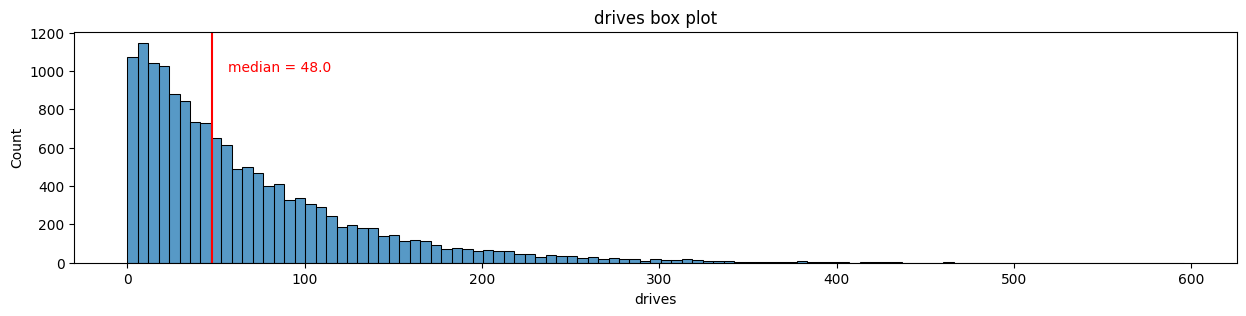

In [561]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['drives'])
median = df['drives'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(57,1000, 'median = ' + str(median), color='red')
plt.title('drives box plot');

Die Variable `drives` folgt einer ähnlichen Verteilung wie die Variable `sessions`.

##### `total_sessions`

Eine Schätzung der gesamten Anzahl von Sessions seit der Registrierung eines Benutzers

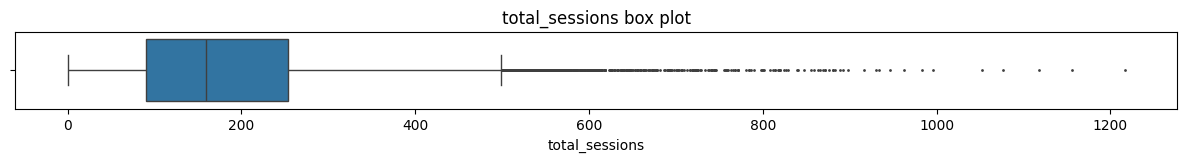

In [562]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['total_sessions'], fliersize=1)
plt.title('total_sessions box plot');

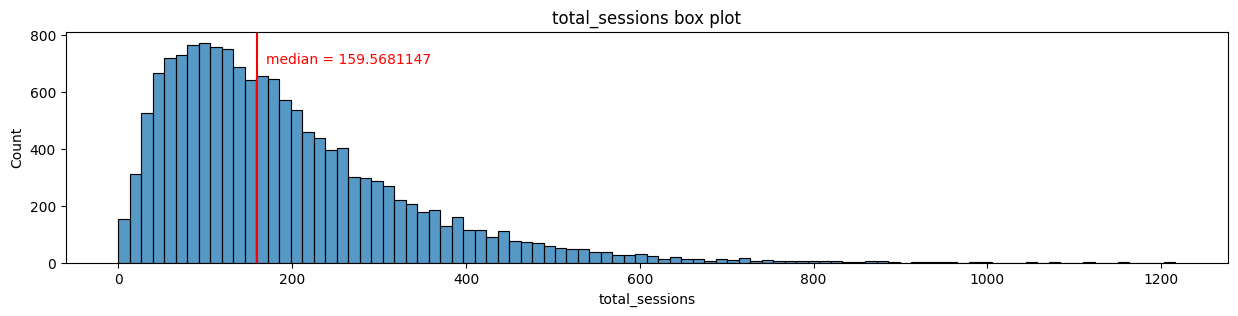

In [563]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['total_sessions'])
median = df['total_sessions'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(170,700, 'median = ' + str(median), color='red')
plt.title('total_sessions box plot');

Die `total_sessions` ist eine rechtsschiefe Verteilung.

##### `n_days_after_onboarding`

Die Anzahl der Tage seit der Registrierung eines Benutzers für die App

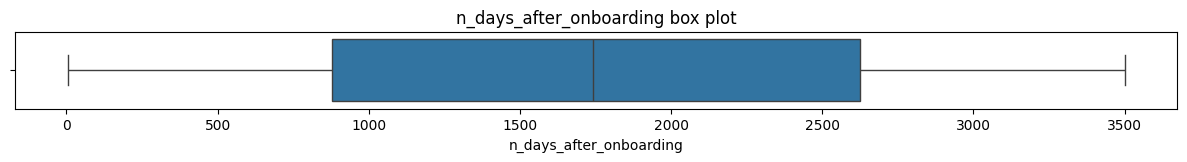

In [564]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['n_days_after_onboarding'], fliersize=1)
plt.title('n_days_after_onboarding box plot');

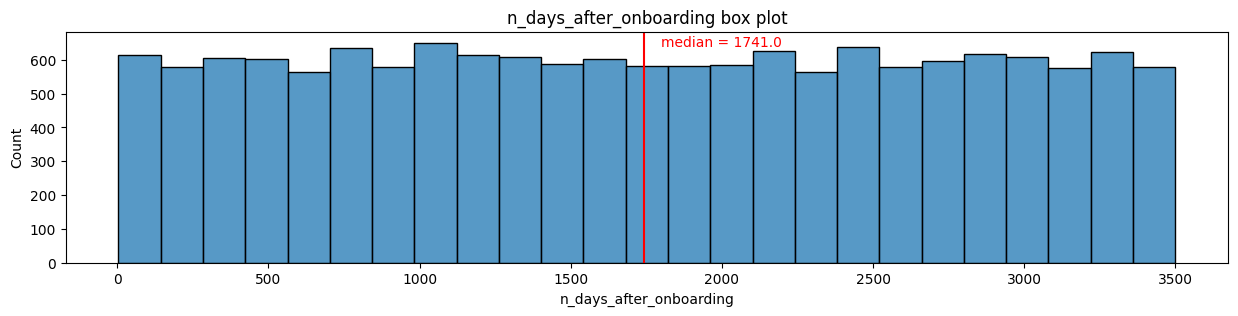

In [565]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['n_days_after_onboarding'])
median = df['n_days_after_onboarding'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(1800,640, 'median = ' + str(median), color='red')
plt.title('n_days_after_onboarding box plot');

Die Variable `n_days_after_onboarding` ist eine Gleichverteilung.

##### `driven_km_drives`

Gesamtkilometerzahl im Monat

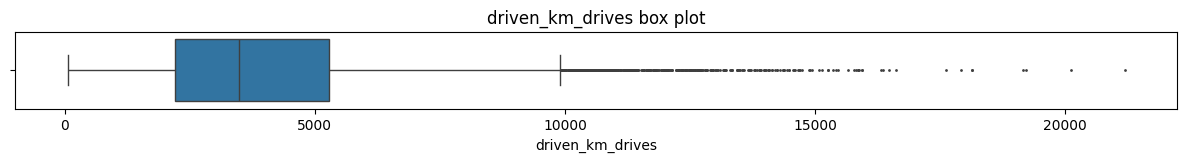

In [566]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['driven_km_drives'], fliersize=1)
plt.title('driven_km_drives box plot');

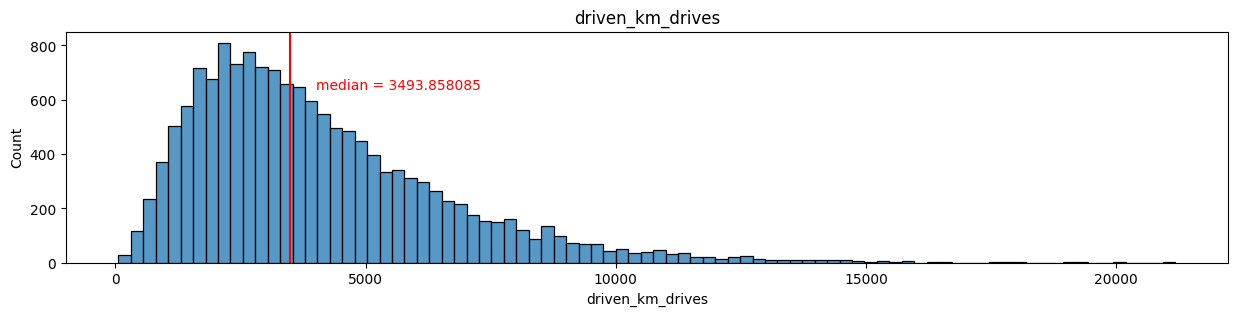

In [567]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['driven_km_drives'])
median = df['driven_km_drives'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(4000,640, 'median = ' + str(median), color='red')
plt.title('driven_km_drives');

Die Variable `driven_km_drives` hat eine rechtsschiefe Verteilung.

##### `duration_minutes_drives`

Gesamtfahrzeit in Minuten während des Monats

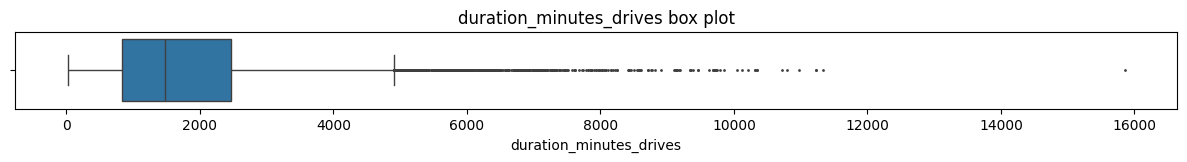

In [568]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['duration_minutes_drives'], fliersize=1)
plt.title('duration_minutes_drives box plot');

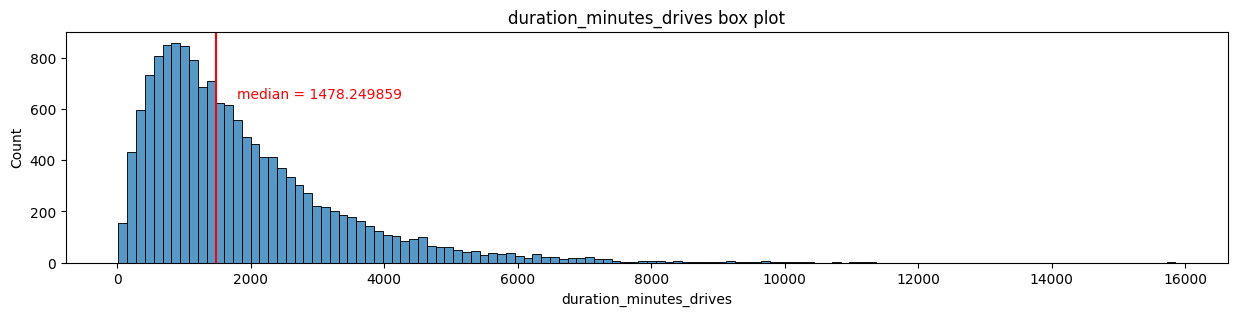

In [569]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['duration_minutes_drives'])
median = df['duration_minutes_drives'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(1800,640, 'median = ' + str(median), color='red')
plt.title('duration_minutes_drives box plot');

Die Variable `duration_minutes_drives` hat eine rechtsschiefe Verteilung.

##### `activity_days`

Anzahl der Tage, an denen der Benutzer die App im Laufe des Monats öffnet

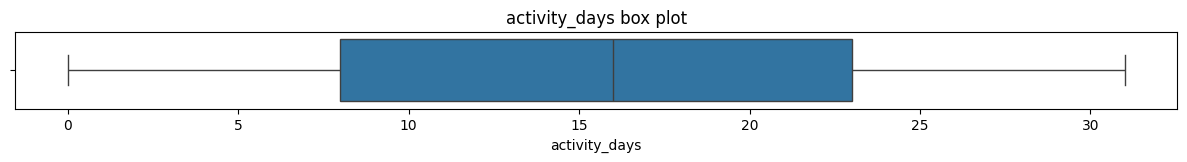

In [570]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['activity_days'], fliersize=1)
plt.title('activity_days box plot');

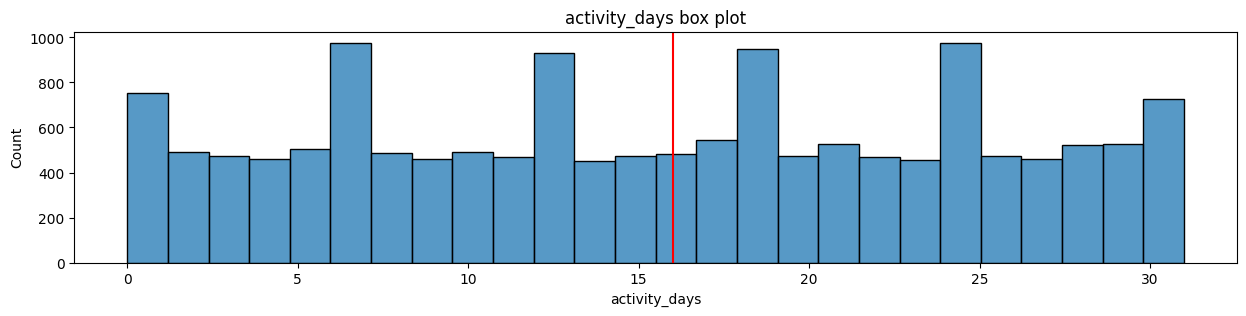

In [571]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['activity_days'])
median = df['activity_days'].median()
plt.axvline(median, color='red', linestyle='-')
#plt.text(1800,640, 'median = ' + str(median), color='red')
plt.title('activity_days box plot');

Im letzten Monat haben die Nutzer die App im Durchschnitt 16 Mal geöffnet. Das Boxplot zeigt eine zentrierte Verteilung. Das Histogramm zeigt eine nahezu gleichmäßige Verteilung.

##### `driving_days`


Anzahl der Tage, an denen der Nutzer im Monat fährt (mindestens 1 km)

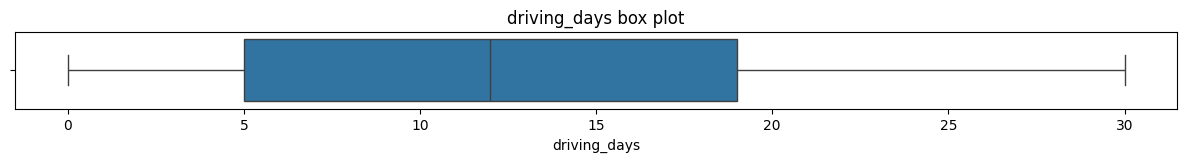

In [572]:
# Box plot
plt.figure(figsize=(15,1))
sns.boxplot(x=df['driving_days'], fliersize=1)
plt.title('driving_days box plot');

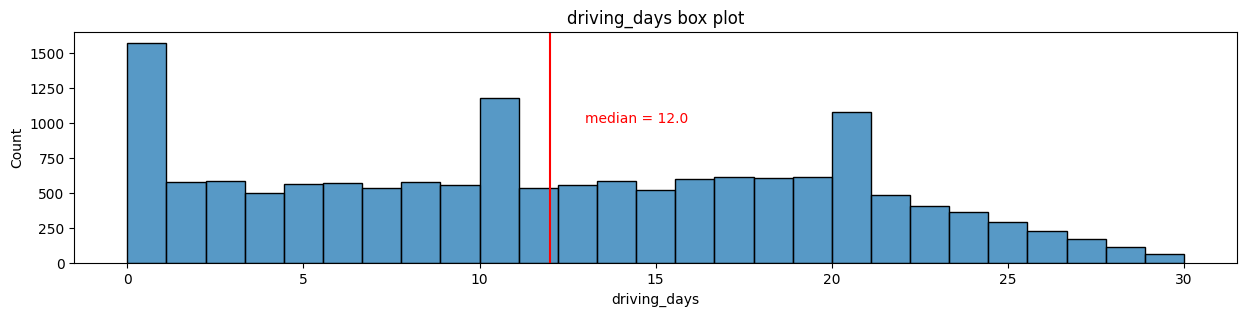

In [573]:
# Histogram
plt.figure(figsize=(15,3))
sns.histplot(x=df['driving_days'])
median = df['driving_days'].median()
plt.axvline(median, color='red', linestyle='-')
plt.text(13,1000, 'median = ' + str(median), color='red')
plt.title('driving_days box plot');

Die Anzahl der Tage, an denen Nutzer jeden Monat gefahren sind, ist nahezu gleichmäßig verteilt und korreliert weitgehend mit der Anzahl der Tage, an denen sie die App in diesem Monat geöffnet haben, mit Ausnahme der Verteilung `driving_days`, die nach rechts hin abfällt.

##### `device`

Der Gerätetyp, mit dem ein Benutzer eine Session startet

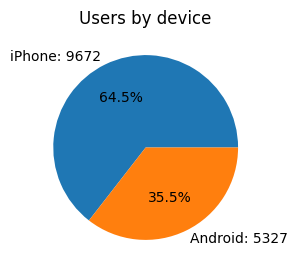

In [574]:
# Pie chart
fig = plt.figure(figsize=(3,3))
data=df['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

##### `label`

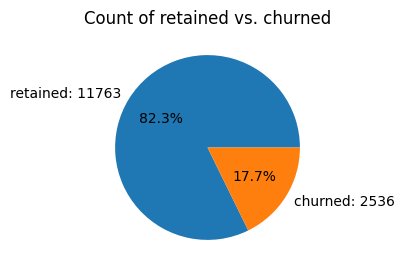

In [575]:
# Pie chart
fig = plt.figure(figsize=(3,3))
data=df['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

#### Beziehungen zwischen Variablen (mehr Grafiken und Figuren)

##### `driving_days` vs. `activity_days`

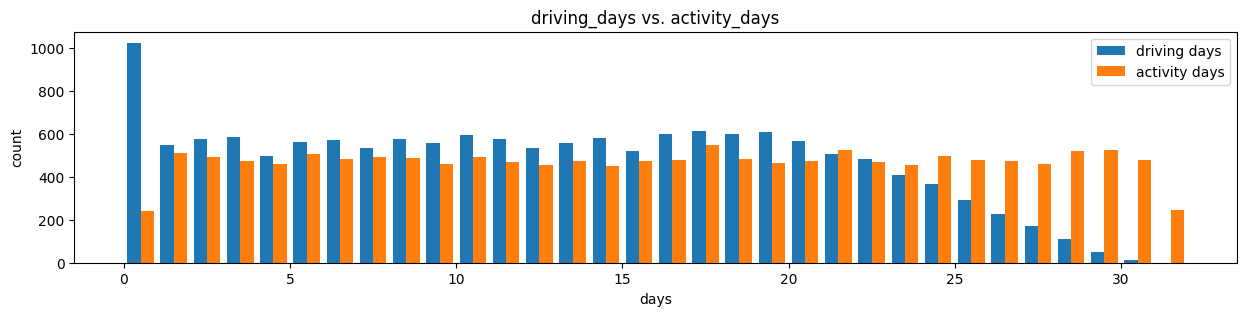

In [576]:
# Histogram
plt.figure(figsize=(15,3))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

Bestätigen Sie die maximale Anzahl von Tagen für jede Variable – `driving_days` und `activity_days`.

In [577]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


Obwohl es möglich ist, dass kein einziger Nutzer an allen 31 Tagen des Monats gefahren ist, ist dies angesichts der Tatsache, dass 15.000 Personen in dem Datensatz vertreten sind, höchst unwahrscheinlich.

##### `device` und `label`

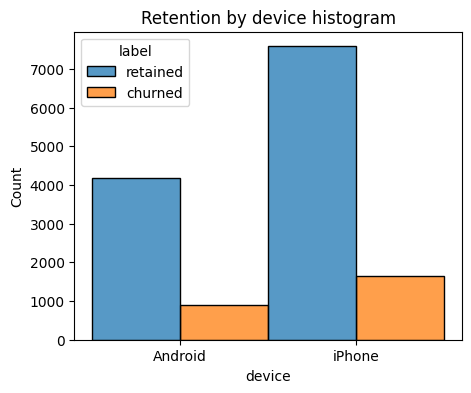

In [578]:
# Histogram
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             )
plt.title('Retention by device histogram');

Der Anteil der abgewanderten Nutzer im Verhältnis zu den gebliebenen Nutzern ist bei allen Gerätetypen gleich.

##### `km_per_driving_day` und `label`

In [579]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

Es gibt Werte für `driving_days` von 0, die wir entfernen müssen.

In [580]:
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

In [581]:
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

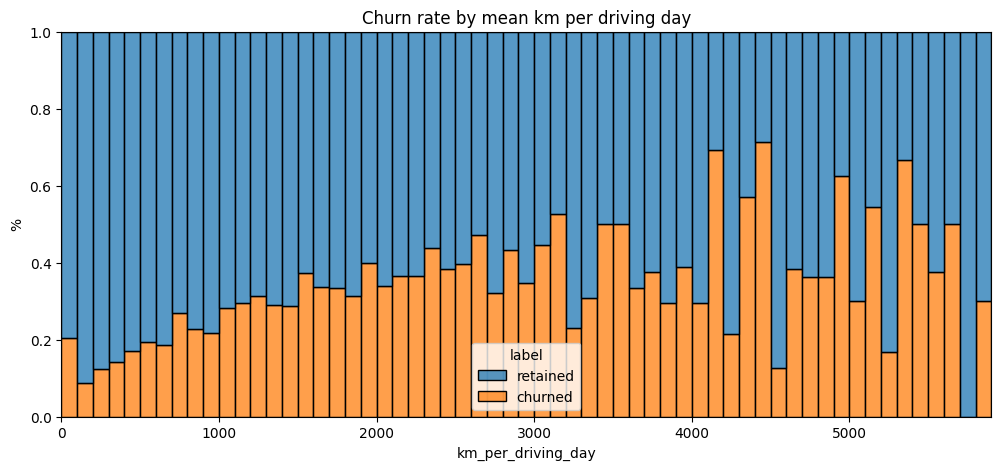

In [582]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,6000,100),
             hue='label',
             multiple='fill')
plt.ylabel('%')
plt.title('Churn rate by mean km per driving day');

Die Abwanderungsrate steigt tendenziell mit der durchschnittlichen täglich gefahrten Distanz, was meine früheren Erkenntnisse bestätigt.

##### `label` und `driving_days`

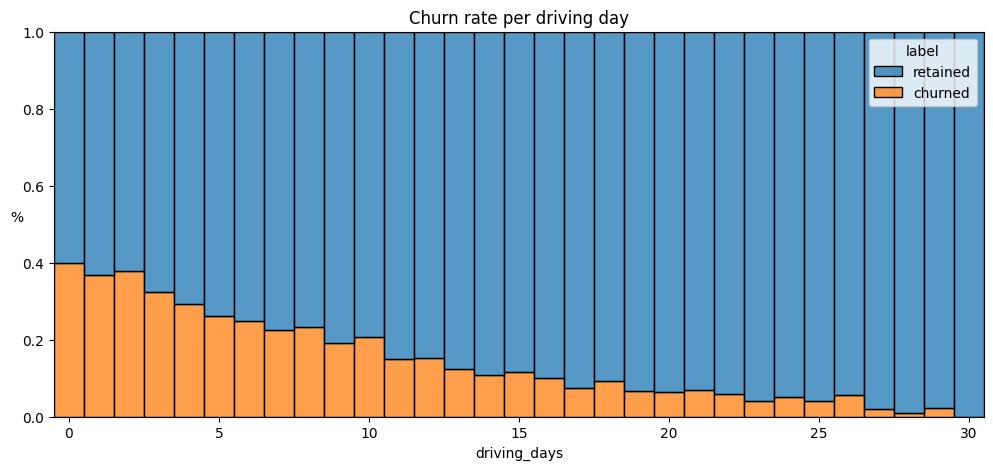

In [583]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

Dies bestätigt auch, dass Menschen, die an weniger Tagen arbeiten, eine höhere Abwanderungsrate haben.

### Hypothesentests durchführen

Ich interessiere mich für die Beziehung zwischen `device` und `driving_days`

In [584]:
print (df.value_counts('device'))

device
iPhone     9672
Android    5327
Name: count, dtype: int64


Wir haben nur 2 Klassen.

In [585]:
android_driving_days = df[df['device'] == "Android"]['driving_days']
iphone_driving_days = df[df['device'] == "iPhone"]['driving_days']

Die Variable `driving_days` enthält extreme Ausreißer. Ich verwende außerdem den Median anstelle des Mittelwerts.

Daher werde ich den Mann-Whitney-U-Test verwenden.

Nullhypothese (H₀): Die Verteilungen von X sind gleich → kein Unterschied in den Medianwerten

Alternativhypothese (H₁): Eine Gruppe tendiert zu höheren oder niedrigeren Werten → Medianwerte unterscheiden sich

In [586]:
# Mann-Whitney U Test with 95% 95% confidence value
stat, p = mannwhitneyu(android_driving_days, iphone_driving_days, alternative='two-sided')

print(f"U statistic = {stat}")
print(f"p-value = {p}")

U statistic = 25899440.0
p-value = 0.5861218904482532


H₀ nicht abgelehnt. Kein signifikanter Unterschied

Auch für die Beziehung zwischen `device` und `driven_km_drives`

In [587]:
android_driven_km = df[df['device'] == "Android"]['driven_km_drives']
iphone_driven_km = df[df['device'] == "iPhone"]['driven_km_drives']


stat, p = mannwhitneyu(android_driven_km, iphone_driven_km, alternative='two-sided')

print(f"U statistic = {stat}")
print(f"p-value = {p}")

U statistic = 25770487.0
p-value = 0.9713499718019984


H₀ nicht abgelehnt. Kein signifikanter Unterschied

Auch für die Beziehung zwischen 

## 3. Konstruktion

### Logistisches Regressionsmodell

#### Feature-Erstellung

Erstellen Sie ein neues binäres Merkmal namens `professional_driver`, das für Benutzer, die im letzten Monat 60 oder mehr Fahrten <u>**und**</u> an mehr als 15 Tagen gefahren sind, den Wert 1 hat.

In [588]:
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

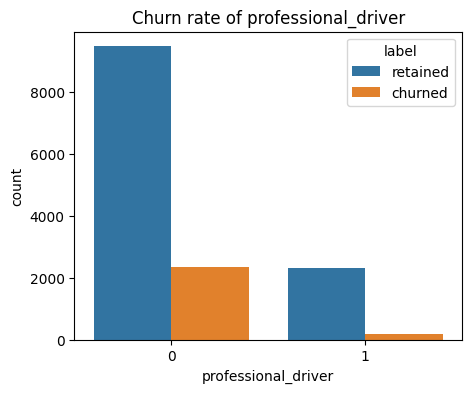

In [589]:
# Countplot
plt.figure(figsize=(5,4))
ax = sns.countplot(
    data=df,
    x='professional_driver',
    hue='label'
)
plt.title('Churn rate of professional_driver')
plt.show()

#### Behandlung von Ausreißern und fehlende Daten

Diese Methode zum Behandlung von Ausreißern hat nicht geklappt. Es gibt viele Variablen, die die Methode zeitaufwändig und fehleranfällig machen.

Von der EDA konnten wir keine Schlussfolgerung für die fehlenden Daten ziehen. Daher löschen wir sie.

In [590]:
# df = df.dropna(subset=['label'])

Aus den obigen Grafiken wissen wir, dass diese Variablen Ausreißer enthalten:
* `sessions`
* `drives`
* `total_sessions`
* `driven_km_drives`
* `duration_minutes_drives`

In [591]:
# df.describe()

Ich plane, die Ausreißer einem Schwellwert zuzuordnen, der anhand des IQR berechnet wird.

In [592]:
def threshold_calc(variable, iqrstop, printbool):

    '''
    In:
            variable (str): the name of the variable to calculate the threshold for
            iqrstop (float): stop value for iqr
    Out:
            iqr (float): the iqr value I will use later when imputing.
    '''
    q3 = df[variable].quantile(0.75)
    q1 = df[variable].quantile(0.25)
    iqr = q3 - q1

    if printbool:
        print ('the 90th percentile is: ' + str(df[variable].quantile(0.90)))
        print ('the 95th percentile is: ' + str(df[variable].quantile(0.95)))
        print ('the 99th percentile is: ' + str(df[variable].quantile(0.99)))
        print ('the median is: ' + str(np.median(df[variable])))

    for iqr_factor in np.arange(1.5, iqrstop, 1.5):
        upper_threshold = q3 + (iqr_factor * iqr)
        if printbool:
            print('the number of observations above upper threshold', upper_threshold, 'with iqr factor', iqr_factor, ':', df[df[variable] >= upper_threshold][variable].value_counts().sum())
    
    return iqr, q3

In [593]:
def imputer(variable, iqrfactor):
    '''
    In:
        variable: variable name (string)
        iqrfactor (float)

    Out:

    '''

    upper_threshold = threshold_calc(variable,3,False)[1] + (iqrfactor * threshold_calc(variable,3,False)[0])
    df.loc[df[variable] > upper_threshold, variable] = upper_threshold

`sessions`

In [594]:
# threshold_calc('sessions',11.1,True)

Der beste IQR-Faktor ist 1,5.

In [595]:
# imputer('sessions',1.5)

`drives`

In [596]:
# threshold_calc('drives',11.1,True)

Auch der beste IQR Faktor ist 1,5

In [597]:
# imputer('drives',1.5)

`total_sessions`

In [598]:
# threshold_calc('total_sessions', 4.6, True)

Auch der beste IQR Faktor ist 1,5

In [599]:
# imputer('total_sessions',1.5)

`driven_km_drives`

In [600]:
# threshold_calc('driven_km_drives',4.6, True)

In [601]:
# imputer('driven_km_drives', 1.5)

`duration_minutes_drives`

In [602]:
# threshold_calc('duration_minutes_drives', 4.6, True)

Der beste IQR-Faktor ist 1.5.

In [603]:
# imputer('duration_minutes_drives', 1.5)

`km_per_driving_day`

In [604]:
# threshold_calc('km_per_driving_day', 11.1, True)

Der beste IQR-Faktor ist 6.

In [605]:
# imputer('km_per_driving_day', 6)

Überprüfen

In [606]:
# df.describe()

#### Behandlung von Ausreißern

In [607]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label', 'drives_per_driving_day'])

Lassen Sie uns noch einmal überprüfen, welche Variablen Ausreißer enthalten.

In [608]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,drives_per_driving_day,professional_driver
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,7503.348237,80.663308,67.288763,189.587148,1751.977120,121.712427,29.633361,4043.899849,1863.986566,15.551147,12.188497,582.227426,9.365001,0.174083
std,4331.344237,80.736547,65.946640,136.200356,1008.610971,147.665950,45.350345,2504.494865,1448.009281,9.013404,7.831111,1038.428849,19.738651,0.379194
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3749.750000,23.000000,20.000000,90.466649,878.750000,10.000000,0.000000,2217.278591,839.816701,8.000000,5.000000,136.238960,1.230769,0.000000
50%,7503.500000,56.000000,48.000000,158.728448,1749.000000,71.000000,9.000000,3496.214642,1479.201628,16.000000,12.000000,273.755019,3.666667,0.000000
75%,11257.250000,112.000000,93.000000,253.564188,2627.250000,178.000000,43.000000,5299.878068,2466.213869,23.000000,19.000000,558.596076,9.000000,0.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15420.234110,395.000000,1.000000


Variablen mit Ausreißern:

- `sessions`
- `drives`
- `total_sessions`
- `total_navigations_fav1`
- `total_navigations_fav2`
- `driven_km_drives`
- `duration_minutes_drives`
- `km_per_driving_day`
- `drives_per_driving_day`

Die Imputation von Ausreißern unter Verwendung des 95. Perzentils ist besser und verursacht weniger Probleme bei der logistischen Regression.

In [609]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives', 'km_per_driving_day', 'drives_per_driving_day']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

Überprüfen

In [610]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,drives_per_driving_day,professional_driver
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.00000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,7503.348237,76.577176,63.996012,183.756361,1751.977120,114.541492,27.18108,3944.208704,1792.610152,15.551147,12.188497,484.822418,7.372968,0.174083
std,4331.344237,67.238299,55.123243,118.730339,1008.610971,124.367123,36.70953,2218.240728,1224.078011,9.013404,7.831111,571.211545,9.520808,0.379194
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.00000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3749.750000,23.000000,20.000000,90.466649,878.750000,10.000000,0.00000,2217.278591,839.816701,8.000000,5.000000,136.238960,1.230769,0.000000
50%,7503.500000,56.000000,48.000000,158.728448,1749.000000,71.000000,9.00000,3496.214642,1479.201628,16.000000,12.000000,273.755019,3.666667,0.000000
75%,11257.250000,112.000000,93.000000,253.564188,2627.250000,178.000000,43.00000,5299.878068,2466.213869,23.000000,19.000000,558.596076,9.000000,0.000000
max,14998.000000,243.000000,200.000000,455.482926,3500.000000,422.000000,124.00000,8898.372505,4666.931419,31.000000,30.000000,2260.424968,36.750000,1.000000


#### Feature Transformation

Kodierung von `label`

In [611]:
df['label'] = np.where(df['label']=='churned', 1, 0)

Kodierung von `device`

In [612]:
df['device'] = np.where(df['device']=='Android', 0, 1)

#### Die Anforderungen der logistische Regression:

1. Unabhängige Observationen
2. Keine extremen Ausreißer
3. Kaum bis keine Multikollinearität zwischen den X-Prädiktoren
4. Lineare Beziehung zwischen X und dem **Logit** von y

Die erste und zweite Anforderungen wurden bereits erfüllt.

##### 3. Multikollinearität

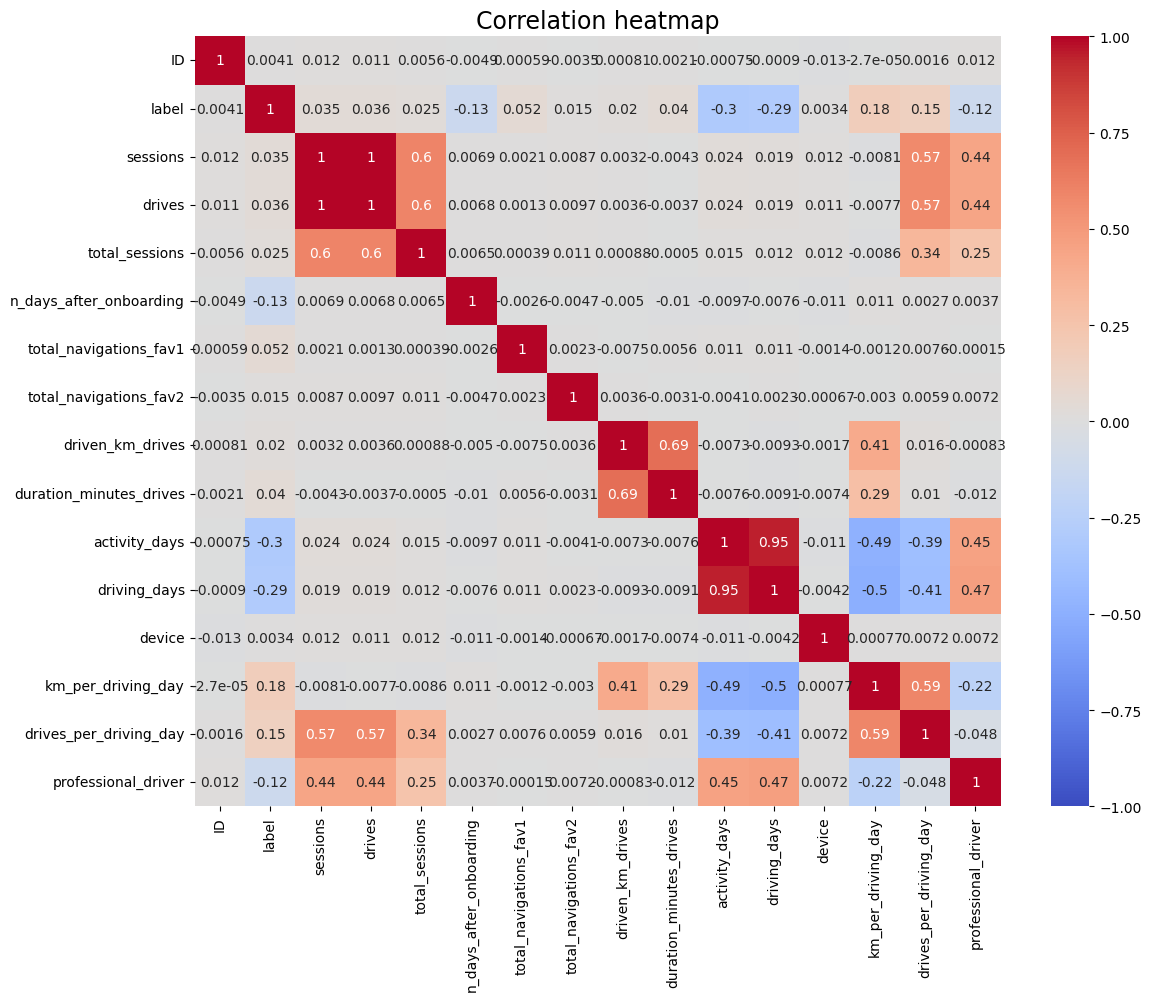

In [613]:
# Plot correlation heatmap
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm',)
plt.title('Correlation heatmap', fontsize=17)
plt.show();

- `drives` und `sessions` sind stark korreliert
- `total_sessions` und `sessions` sind mäßig korreliert
- `total_sessions` und `drives` sind mäßig korreliert
- `driving_day` und `activity_day` sind stark korreliert

Das ist erwartet.

#### Feature Selection

In [614]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14292 entries, 0 to 14998
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14292 non-null  int64  
 1   label                    14292 non-null  int64  
 2   sessions                 14292 non-null  int64  
 3   drives                   14292 non-null  int64  
 4   total_sessions           14292 non-null  float64
 5   n_days_after_onboarding  14292 non-null  int64  
 6   total_navigations_fav1   14292 non-null  int64  
 7   total_navigations_fav2   14292 non-null  int64  
 8   driven_km_drives         14292 non-null  float64
 9   duration_minutes_drives  14292 non-null  float64
 10  activity_days            14292 non-null  int64  
 11  driving_days             14292 non-null  int64  
 12  device                   14292 non-null  int64  
 13  km_per_driving_day       14292 non-null  float64
 14  drives_per_driving_day   14

**Y-Variable**

In [615]:
y = df['label']

**X-Variablen**

In [616]:
X = df.drop(columns = ['label', 'device', 'sessions', 'driving_days', 'drives_per_driving_day'])

#### Aufteilung der Daten in Trainings- und Testdatensätze

In [617]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [618]:
X.describe()

,ID,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.00000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,7503.348237,63.996012,183.756361,1751.977120,114.541492,27.18108,3944.208704,1792.610152,15.551147,484.822418,0.174083
std,4331.344237,55.123243,118.730339,1008.610971,124.367123,36.70953,2218.240728,1224.078011,9.013404,571.211545,0.379194
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.00000,60.441250,18.282082,0.000000,0.000000,0.000000
25%,3749.750000,20.000000,90.466649,878.750000,10.000000,0.00000,2217.278591,839.816701,8.000000,136.238960,0.000000
50%,7503.500000,48.000000,158.728448,1749.000000,71.000000,9.00000,3496.214642,1479.201628,16.000000,273.755019,0.000000
75%,11257.250000,93.000000,253.564188,2627.250000,178.000000,43.00000,5299.878068,2466.213869,23.000000,558.596076,0.000000
max,14998.000000,200.000000,455.482926,3500.000000,422.000000,124.00000,8898.372505,4666.931419,31.000000,2260.424968,1.000000


#### Modell instanziieren

In [619]:
model = LogisticRegression(penalty = None, max_iter=3000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=3000, penalty=None)

In [620]:
pd.Series(model.coef_[0], index=X.columns)

ID                         0.000004
drives                     0.001862
total_sessions             0.000394
n_days_after_onboarding   -0.000396
total_navigations_fav1     0.001210
total_navigations_fav2     0.000951
driven_km_drives          -0.000029
duration_minutes_drives    0.000117
activity_days             -0.099245
km_per_driving_day         0.000085
professional_driver       -0.047861
dtype: float64

In [621]:
model.intercept_

array([-0.11871893])

#### Überprüfung der vierten Anforderung der logistischen Regression

In [622]:
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93845715, 0.06154285],
       [0.64298362, 0.35701638],
       [0.88593286, 0.11406714],
       ...,
       [0.54217288, 0.45782712],
       [0.83350261, 0.16649739],
       [0.92479826, 0.07520174]], shape=(11433, 2))

In [623]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

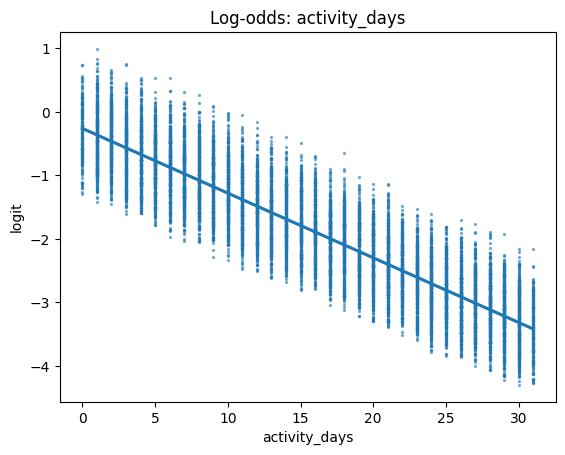

In [624]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

#### Results and Evaluation

Wir achten bei diesem Projekt besonders auf True Positives (echte Positive), daher wird unsere Hauptevaluierungsbewertung die Recall sein.

In [625]:
# Results and Evaluation:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

log_reg_results_table = pd.DataFrame({'model': ["Logistic Regression"],
                        'f1':  [f1],
                        'recall': [recall],
                        'precision': [precision],
                        'accuracy': [accuracy],
                      }
                    )



log_reg_results_table

,model,f1,recall,precision,accuracy
0,Logistic Regression,0.171429,0.100592,0.579545,0.827562


Confusion Matrix

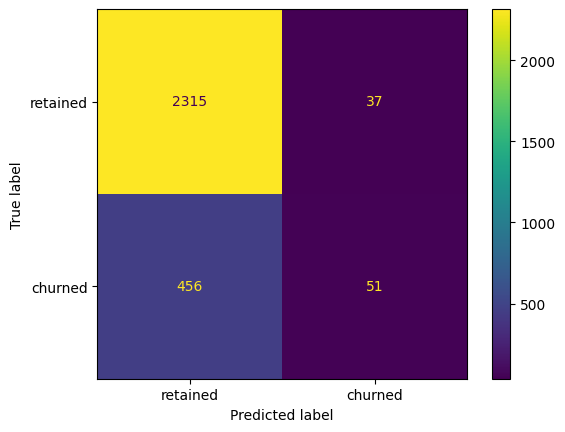

In [626]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

### Maschinelle Lernmodelle

#### Feature Erstellen

**`percent_sessions_in_last_month`**

In [627]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']
df['percent_sessions_in_last_month'].describe()

count    14292.000000
mean         0.444277
std          0.278392
min          0.000000
25%          0.200538
50%          0.428186
75%          0.665134
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

**`total_sessions_per_day`**

In [628]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
df['total_sessions_per_day'].describe()

count    14292.000000
mean         0.330112
std          1.292761
min          0.000298
25%          0.050855
50%          0.100482
75%          0.208579
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [629]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14292 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14292 non-null  int64  
 1   label                           14292 non-null  int64  
 2   sessions                        14292 non-null  int64  
 3   drives                          14292 non-null  int64  
 4   total_sessions                  14292 non-null  float64
 5   n_days_after_onboarding         14292 non-null  int64  
 6   total_navigations_fav1          14292 non-null  int64  
 7   total_navigations_fav2          14292 non-null  int64  
 8   driven_km_drives                14292 non-null  float64
 9   duration_minutes_drives         14292 non-null  float64
 10  activity_days                   14292 non-null  int64  
 11  driving_days                    14292 non-null  int64  
 12  device                          14292

#### Random Forest mit GridsearchCV

In [630]:
X = df.drop(columns=['label', 'device'])

y = df['label']

In [631]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [632]:
rf = RandomForestClassifier(random_state=42)

cv_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [None, 0.8, 1.0]
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall', n_jobs=-1, verbose=2)

In [633]:
#rf_cv.fit(X_train, y_train)

##### Pickle

In [634]:
# Pickling because this model takes a long time to run:

path = 'pickled_models/'

def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model




In [635]:
# Write pickle
#write_pickle(path, rf_cv, 'rf_cv')


In [636]:
# Read pickle
rf_cv = read_pickle(path, 'rf_cv')

##### Ergebnisse

In [637]:
rf_cv.best_score_

np.float64(0.1356784041841513)

In [638]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': 1.0,
 'max_samples': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [639]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores and the y-preds of the X test data.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
    
    return table, preds

In [640]:
randomforest_results_table_train = get_scores('Random Forest 1 train', rf_cv, X_train, y_train)
final_results_table = randomforest_results_table_train[0]

In [641]:
randomforest_results_table_test = get_scores('Random Forest 1 test', rf_cv, X_test, y_test)
final_results_table = pd.concat([log_reg_results_table, randomforest_results_table_train[0], randomforest_results_table_test[0]])
final_results_table

,model,f1,recall,precision,accuracy,AUC
0,Logistic Regression,0.171429,0.100592,0.579545,0.827562,NaN
0,Random Forest 1 train,0.996286,0.992600,1.000000,0.998688,0.996300
0,Random Forest 1 test,0.176471,0.112426,0.410072,0.813921,0.538781


Confusion Matrix

In [642]:
def plot_confusion_matrix(results_table):
    '''
    In:
        results_table: the variable used for get_scores.
    Out:
        A confusion matrix
    '''
    

    cm = confusion_matrix(y_test, results_table[1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
    disp.plot();

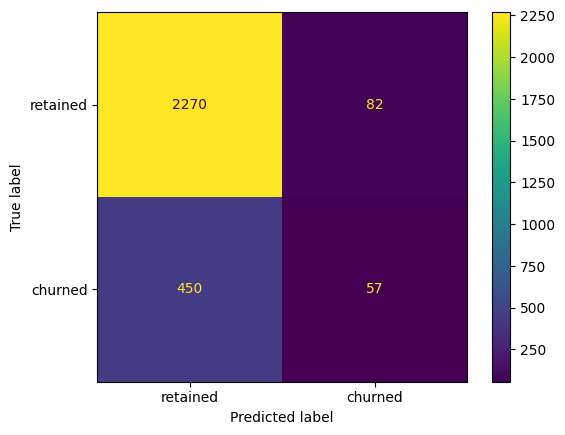

In [643]:
plot_confusion_matrix(randomforest_results_table_test)

#### XGBoost Modell

In [644]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)


cv_params = {
    'max_depth': [3, 6, 12],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],                        
    'reg_lambda': [1, 5]                    
}


scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall', n_jobs=-1, verbose=2)

In [645]:
#xgb_cv.fit(X_train, y_train)

In [646]:
# Write pickle
#write_pickle(path, xgb_cv, 'xgb_cv')


In [647]:
# Read pickle
xgb_cv = read_pickle(path, 'xgb_cv')

##### Ergebnisse

In [648]:
xgb_cv.best_score_

np.float64(0.16478014960773582)

In [649]:
xgb_cv.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 500,
 'reg_lambda': 1,
 'subsample': 0.8}

In [650]:
xgb_results_table_train = get_scores('xgb 1 train', xgb_cv, X_train, y_train)

In [651]:
xgb_results_table_test = get_scores('xgb 1 test', xgb_cv, X_test, y_test)
final_results_table = pd.concat([final_results_table, xgb_results_table_train[0], xgb_results_table_test[0]])
final_results_table

,model,f1,recall,precision,accuracy,AUC
0,Logistic Regression,0.171429,0.100592,0.579545,0.827562,NaN
0,Random Forest 1 train,0.996286,0.992600,1.000000,0.998688,0.996300
0,Random Forest 1 test,0.176471,0.112426,0.410072,0.813921,0.538781
0,xgb 1 train,1.000000,1.000000,1.000000,1.000000,1.000000
0,xgb 1 test,0.231087,0.165680,0.381818,0.804477,0.553929


Confusion Matrix

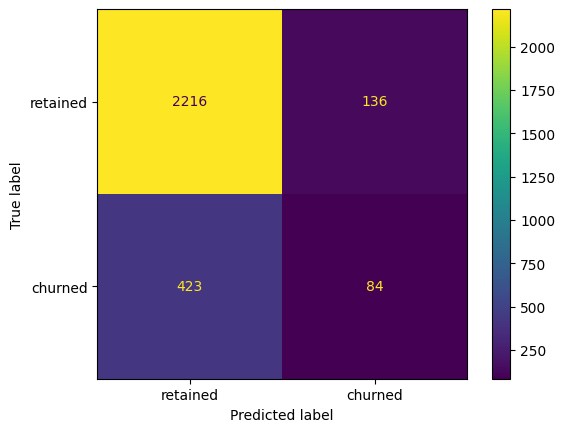

In [652]:
plot_confusion_matrix(xgb_results_table_test)

##### Feature Importance

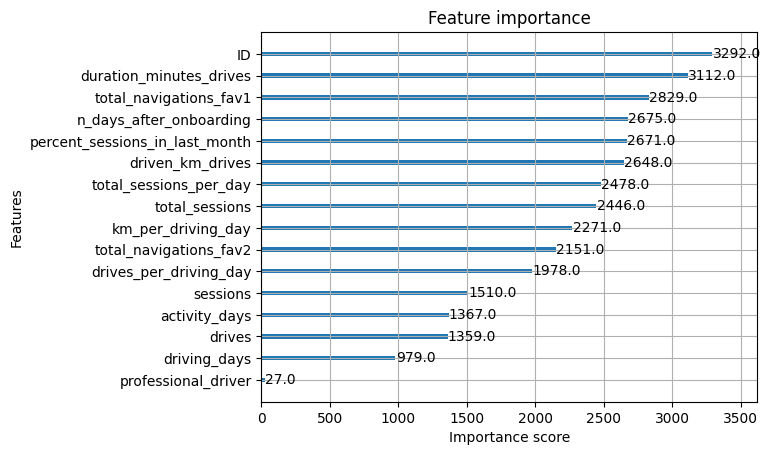

In [653]:
plot_importance(xgb_cv.best_estimator_);

Alle diese Modelle sind schlecht und überanpassen sich an die Daten.

Lassen Sie uns versuchen, das Problem zu beheben, indem wir den Wahrscheinlichkeitsschwellenwert ändern.

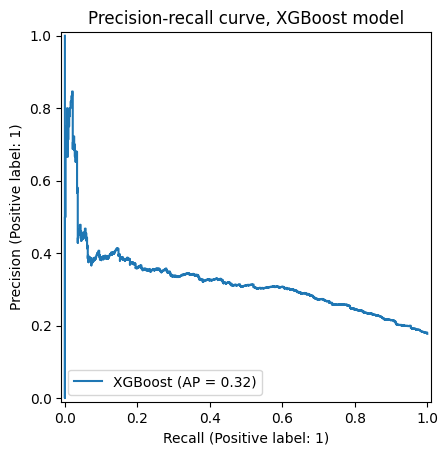

In [654]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');
plt.show()

In [655]:
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.9970168 , 0.00298324],
       [0.99887943, 0.00112059],
       [0.99632376, 0.00367624],
       ...,
       [0.99604326, 0.00395673],
       [0.9929244 , 0.00707562],
       [0.67532396, 0.324676  ]], shape=(2859, 2), dtype=float32)

In [656]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0], shape=(2859,))

In [657]:
accuracy = accuracy_score(y_test, new_preds)
precision = precision_score(y_test, new_preds)
recall = recall_score(y_test, new_preds)
f1 = f1_score(y_test, new_preds)

table_xgb_04 = pd.DataFrame({'model': 'XGB, threshold = 0.4',
                          'f1': [f1],
                          'recall': [recall],
                          'precision': [precision],
                          'accuracy': [accuracy]
                     })

In [658]:
final_results_table = pd.concat([final_results_table, table_xgb_04])
final_results_table

,model,f1,recall,precision,accuracy,AUC
0,Logistic Regression,0.171429,0.100592,0.579545,0.827562,NaN
0,Random Forest 1 train,0.996286,0.992600,1.000000,0.998688,0.996300
0,Random Forest 1 test,0.176471,0.112426,0.410072,0.813921,0.538781
0,xgb 1 train,1.000000,1.000000,1.000000,1.000000,1.000000
0,xgb 1 test,0.231087,0.165680,0.381818,0.804477,0.553929
0,"XGB, threshold = 0.4",0.267327,0.213018,0.358804,0.792935,NaN


## 4. Abschluss

**Ich würde keinem Unternehmen empfehlen, dieses Modell zu verwenden.**

Nächste Schritte:

- Skalieren Sie die Merkmale/Variablen und verwenden Sie eine logistische Regression mit geringerer Iteration.
- Es wäre hilfreich, für jeden Nutzer Informationen auf Fahrerebene zu haben (z. B. Fahrzeiten, geografische Standorte usw.). Es wäre wahrscheinlich auch hilfreich, detailliertere Daten zu haben, um zu erfahren, wie Nutzer mit der App interagieren.